In [1]:
import os

def get_repo_dir():
    cwd = os.getcwd()
    splited = cwd.split('/')
    ind = splited.index('fsCounter')
    repo_dir = '/'
    for s in splited[1:ind + 1]:
        repo_dir = os.path.join(repo_dir, s)

    return repo_dir

In [5]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display



sys.path.append(get_repo_dir())

from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *
from vision.tools.post_process_analysis import read_tracks_and_slices, get_block_count
from vision.visualization.draw_bb_from_csv import draw_tree_bb_from_tracks

In [6]:
def concat_to_meta(block_meta, df):
    df_col = list(block_meta.columns)
    df['block'] = df['block'].str.lower()
    new_data = []
    data = block_meta.copy()
    for id_, sample in data.iterrows():
        block = sample['block'].lower()
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        #print(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        q_data = df.query(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        new_sample = sample.to_list()
        for i in range(1, 4):
            new_sample.append(q_data[str(i)].values[0])
        new_data.append(new_sample)

    df_col += ['cv1', 'cv2', 'cv3']
    new_df = pd.DataFrame(new_data, columns=df_col)

    return new_df

def add_ratios(df):
    df['F/cv1'] = df['F'] / df['cv1']
    df['F/cv2'] = df['F'] / df['cv2']
    df['F/cv3'] = df['F'] / df['cv3']

    return df

def get_block_ratio(block_df, row_tracks, y_threshold=800, depth=3):
    block_col = list(block_df.columns)
    new_data = []
    for id_, sample in block_df.iterrows():
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        tree_df = row_tracks[row][tree_id]

        d_tree_df = tree_df.query(f'depth <= {depth}')
        
        
        lower_tree_df = tree_df.query(f'y1 > {y_threshold} and depth <= {depth}')
        count = len(tree_df.track_id.unique())
        lower_count = len(lower_tree_df.track_id.unique())
        ratio = lower_count / count

        gdf = lower_tree_df.groupby('track_id')
        lower_tracks_depth = np.array(gdf.depth.mean())
        filtered_lower_tracks_depth = lower_tracks_depth[lower_tracks_depth < 3]
        mean = np.mean(filtered_lower_tracks_depth)
        std = np.std(filtered_lower_tracks_depth)          
        
        new_sample = sample.to_list()
 
        uniq, counts = np.unique(d_tree_df["track_id"], return_counts=True)
        for i in range(0, 5):
            new_sample.append(len(uniq[counts>i]))
            
        new_data.append(new_sample)

    #block_col += ['y_ratio', 'mean', 'std', 'lcv1', 'lcv2', 'lcv3', 'lcv4', 'lcv5']
    block_col += ['dcv1', 'dcv2', 'dcv3', 'dcv4', 'dcv5']
    new_df = pd.DataFrame(new_data, columns=block_col)

    return new_df 

In [7]:
def linear_model_selection(data, selection_cols=["cv1"], type_col="block", cross_val='row'):

    factors = {}
    for col in selection_cols:
        factor, res_mean, res_std, tree_mean, tree_std, all_preds = run_LROCV(data, cv_col=col, type_col=type_col, cross_val=cross_val, return_res=True)
        factors[col] = {'factor': factor, 'mean_error': res_mean, 'std_error': res_std}

    return factors
    

In [77]:
def block_analysis(block_path, metadata_path, block_):
    block_counts, row_tracks = get_block_count(block_path)
    block_counts_df = pd.DataFrame(block_counts, columns=['tree_id', 'block', 'row', '1', '2','3'])
    meta_data = pd.read_csv(metadata_path)
    block_meta = meta_data.query(f'block == "{block_}"')
    block_df = concat_to_meta(block_meta, block_counts_df)
    block_df['F/cv1'] = block_df['F'] / block_df['cv1'] 
    block_df= add_ratios(block_df)
    block_df = get_block_ratio(block_df, row_tracks)

    return block_df, row_tracks

In [9]:
def get_selection_error(factors_dict, block_df):
    results = {}
    for item_ in list(factors_dict.keys()):
        block_df[f'err_{item_}'] = (block_df['F'] - (block_df[item_] * factors_dict[item_]['factor'])) / block_df['F']
        results[item_] = {'err': np.mean(block_df[f'err_{item_}']), 'err_std': np.std(block_df[f'err_{item_}'])}

    return results, block_df

In [10]:
metadata_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/counting/data_meta.csv"

# Block 5

In [78]:
block_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/5XXXXXX2"
block_ = '5XXXXXX2'
block_13_df, row_tracks_13 = block_analysis(block_path, metadata_path, block_)

In [79]:
block_13_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,F/cv2,F/cv3,dcv1,dcv2,dcv3,dcv4,dcv5
0,5XXXXXX2,row_1,1,1,150,255,207,187,0.588235,0.724638,0.802139,213,170,145,132,117
1,5XXXXXX2,row_2,1,1,150,194,167,139,0.773196,0.898204,1.079137,161,137,119,110,92
2,5XXXXXX2,row_4,2,1,130,209,171,141,0.622010,0.760234,0.921986,173,135,116,98,87
3,5XXXXXX2,row_5,2,1,130,179,132,107,0.726257,0.984848,1.214953,163,123,99,85,68


In [16]:
row_to_drow = 'row_5'
tree_id = 1
date = '281123'
draw_tree_bb_from_tracks(row_tracks_13[row_to_drow][tree_id], os.path.join(block_path, date, row_to_drow, '1'), tree_id)

saving data into: /home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/5XXXXXX2/281123/row_5/1/trees/1
arranging data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:20<00:00,  2.34it/s]


Done


Text(0, 0.5, 'F/CV1')

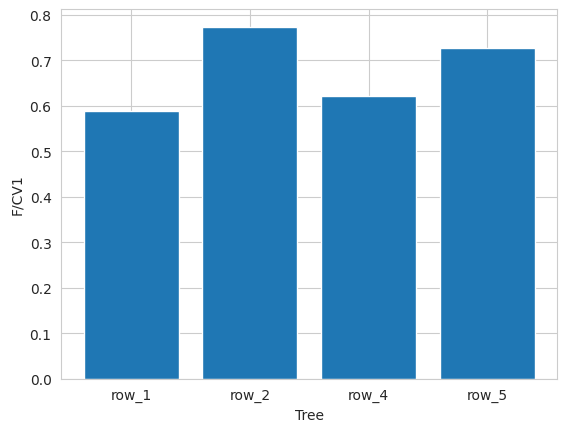

In [21]:
plt.bar(block_13_df['row'], block_13_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

<Figure size 1000x600 with 0 Axes>

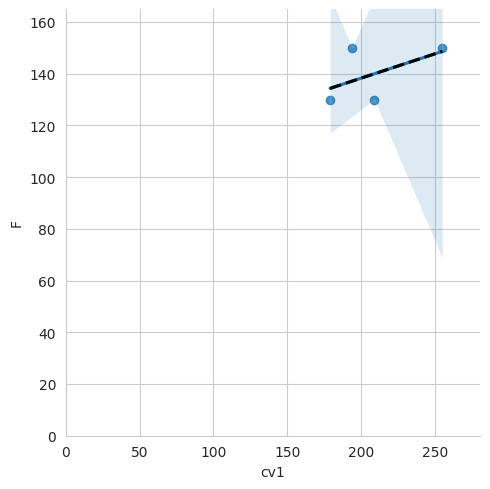

In [81]:
plot_F_cv(block_13_df, 1, add_xy_line=False)

In [82]:
factors_13_dict = linear_model_selection(block_13_df, selection_cols=['cv1','dcv1','cv2','dcv2', 'cv3', 'dcv3'],type_col="block", cross_val='row')

true: 130,    pred: 115.61328941793879. (11.07 %) (row_5)
true: 130,    pred: 140.60355451292486. (8.16 %) (row_4)
true: 150,    pred: 122.24672639558928. (18.50 %) (row_2)
true: 150,    pred: 178.92605726988836. (19.28 %) (row_1)
0.14252375356290758 0.04761452812508164
(0.14252375356290758, 0.04761452812508164)
[0.66032077]
true: 130,    pred: 115.61328941793879. (11.07 %) (row_5)
true: 130,    pred: 140.60355451292486. (8.16 %) (row_4)
true: 150,    pred: 122.24672639558928. (18.50 %) (row_2)
true: 150,    pred: 178.92605726988836. (19.28 %) (row_1)
0.14252375356290758 0.04761452812508164
true: 130,    pred: 126.55894644286151. (2.65 %) (row_5)
true: 130,    pred: 136.63710031780423. (5.11 %) (row_4)
true: 150,    pred: 119.5326258749153. (20.31 %) (row_2)
true: 150,    pred: 175.29683689440537. (16.86 %) (row_1)
0.11232141684327074 0.07506694355619034
(0.11232141684327074, 0.07506694355619034)
[0.78082449]
true: 130,    pred: 126.55894644286151. (2.65 %) (row_5)
true: 130,    pred: 

In [83]:
res, block_13_df = get_selection_error(factors_13_dict, block_13_df)
res

{'cv1': {'err': -0.04863803398445882, 'err_std': 0.1160067436392939},
 'dcv1': {'err': -0.04477505653569409, 'err_std': 0.10501635169342237},
 'cv2': {'err': -0.0424161320343953, 'err_std': 0.12759069288328576},
 'dcv2': {'err': -0.04585329966543617, 'err_std': 0.08900218216341924},
 'cv3': {'err': -0.06938486546194218, 'err_std': 0.1682297657593536},
 'dcv3': {'err': -0.044645316733616214, 'err_std': 0.09941958728670636}}

In [85]:
block_13_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,F/cv2,...,dcv2,dcv3,dcv4,dcv5,err_cv1,err_dcv1,err_cv2,err_dcv2,err_cv3,err_dcv3
0,5XXXXXX2,row_1,1,1,150,255,207,187,0.588235,0.724638,...,170,145,132,117,-0.192840,-0.168646,-0.192789,-0.176103,-0.306697,-0.183210
1,5XXXXXX2,row_2,1,1,150,194,167,139,0.773196,0.898204,...,137,119,110,92,0.092506,0.116658,0.037702,0.052200,0.028712,0.028952
2,5XXXXXX2,row_4,2,1,130,209,171,141,0.622010,0.760234,...,135,116,98,87,-0.128071,-0.095210,-0.136939,-0.077651,-0.136843,-0.092193
3,5XXXXXX2,row_5,2,1,130,179,132,107,0.726257,0.984848,...,123,99,85,68,0.033853,-0.031903,0.122363,0.018141,0.137289,0.067869


In [86]:
factors_13_dict


{'cv1': {'factor': array([0.70167081]),
  'mean_error': 0.14252375356290758,
  'std_error': 0.04761452812508164},
 'dcv1': {'factor': array([0.82298984]),
  'mean_error': 0.11232141684327074,
  'std_error': 0.07506694355619034},
 'cv2': {'factor': array([0.86433994]),
  'mean_error': 0.1535542395702206,
  'std_error': 0.046566355857971566},
 'dcv2': {'factor': array([1.03773766]),
  'mean_error': 0.10565852647144997,
  'std_error': 0.05583182070374544},
 'cv3': {'factor': array([1.04815305]),
  'mean_error': 0.18856423461150118,
  'std_error': 0.10294884736046551},
 'dcv3': {'factor': array([1.22400983]),
  'mean_error': 0.11936805457829362,
  'std_error': 0.0523406564897393}}

# Block 1

In [32]:
block_21_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/1XXXXXX4"
block_21 = '1XXXXXX4'
block_21_df, row_tracks_21 = block_analysis(block_21_path, metadata_path, block_21)

In [33]:
block_21_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,1XXXXXX4,row_3,1,1,130,199,156,135,0.653266,193,147,124,108,90
1,1XXXXXX4,row_6,1,1,130,179,146,136,0.726257,170,142,135,119,110
2,1XXXXXX4,row_7,2,1,150,207,164,149,0.724638,198,158,141,126,115
3,1XXXXXX4,row_8,2,1,150,195,139,126,0.769231,180,133,121,111,100


<Figure size 1000x600 with 0 Axes>

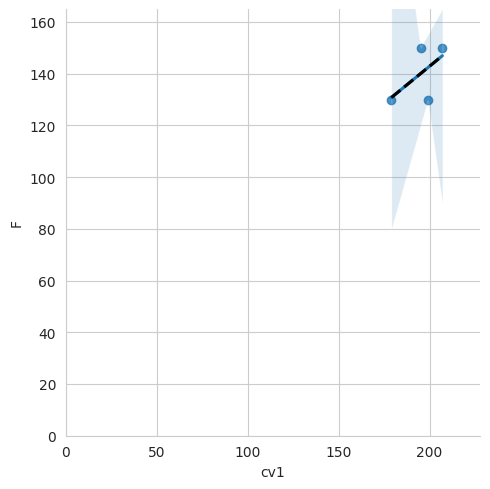

In [34]:
plot_F_cv(block_21_df, 1, add_xy_line=False)

In [70]:
factors_21_dict = linear_model_selection(block_21_df, selection_cols=['cv1','dcv1','cv2','dcv2', 'cv3', 'dcv3'],type_col="block", cross_val='row')



true: 150,    pred: 136.57885772680822. (8.95 %) (row_8)
true: 150,    pred: 147.96365360591608. (1.36 %) (row_7)
true: 130,    pred: 128.03013073251708. (1.52 %) (row_6)
true: 130,    pred: 147.28273480051365. (13.29 %) (row_3)
0.06278671970442726 0.050806009679941935
(0.06278671970442726, 0.050806009679941935)
[0.71756406]
true: 150,    pred: 136.57885772680822. (8.95 %) (row_8)
true: 150,    pred: 147.96365360591608. (1.36 %) (row_7)
true: 130,    pred: 128.03013073251708. (1.52 %) (row_6)
true: 130,    pred: 147.28273480051365. (13.29 %) (row_3)
0.06278671970442726 0.050806009679941935
true: 150,    pred: 131.36977589627247. (12.42 %) (row_8)
true: 150,    pred: 149.0590467686126. (0.63 %) (row_7)
true: 130,    pred: 127.73465131875098. (1.74 %) (row_6)
true: 130,    pred: 151.32134044416142. (16.40 %) (row_3)
0.07797764644072444 0.06772434527061011
(0.07797764644072444, 0.06772434527061011)
[0.75417595]
true: 150,    pred: 131.36977589627247. (12.42 %) (row_8)
true: 150,    pred: 

In [71]:
factors_21_dict

{'cv1': {'factor': array([0.74011425]),
  'mean_error': 0.06278671970442726,
  'std_error': 0.050806009679941935},
 'dcv1': {'factor': array([0.7840484]),
  'mean_error': 0.07797764644072444,
  'std_error': 0.06772434527061011},
 'cv2': {'factor': array([0.95405209]),
  'mean_error': 0.09674340378059909,
  'std_error': 0.07034409575486834},
 'dcv2': {'factor': array([0.98874508]),
  'mean_error': 0.09742985350329571,
  'std_error': 0.06197853968551388},
 'cv3': {'factor': array([1.04166298]),
  'mean_error': 0.0939283301531846,
  'std_error': 0.055997950786554215},
 'dcv3': {'factor': array([1.07778641]),
  'mean_error': 0.0910740273032399,
  'std_error': 0.0728202924246124}}

In [72]:
res, block_block_21_df13_df = get_selection_error(factors_21_dict, block_21_df)
res

{'cv1': {'err': -0.03388266871949286, 'err_std': 0.06191716583050602},
 'dcv1': {'err': -0.041276581414287306, 'err_std': 0.07975429291192038},
 'cv2': {'err': -0.035880407185547095, 'err_std': 0.09517999481012553},
 'dcv2': {'err': -0.029055461468661642, 'err_std': 0.09204052416264209},
 'cv3': {'err': -0.020295538281150237, 'err_std': 0.08648125596470378},
 'dcv3': {'err': -0.0074539419668052526, 'err_std': 0.08945245609746674}}

In [ ]:
#row_to_drow = 'row_1111'
#tree_id = 1
#draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

Text(0, 0.5, 'F/CV1')

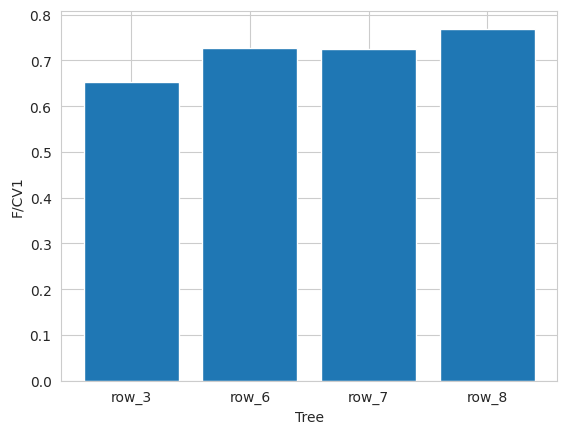

In [63]:
plt.bar(block_21_df['row'], block_21_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

# Block 7 

In [47]:
block_48_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/7XXXXXX2"
block_48 = '7XXXXXX2'
block_48_df, row_tracks_48 = block_analysis(block_48_path, metadata_path, block_48)

In [48]:
block_48_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,7XXXXXX2,row_1,1,1,230,425,346,313,0.541176,317,230,204,172,151
1,7XXXXXX2,row_4,1,1,230,364,310,284,0.631868,245,191,163,140,127
2,7XXXXXX2,row_5,2,1,339,355,302,269,0.954930,306,237,195,166,146
3,7XXXXXX2,row_6,2,1,339,320,273,235,1.059375,287,244,204,185,165


In [67]:
factors_48_dict = linear_model_selection(block_48_df, selection_cols=['cv1','dcv1','cv2','dcv2', 'cv3', 'dcv3'],type_col="block", cross_val='row')

true: 339,    pred: 219.92867975570775. (35.12 %) (row_6)
true: 339,    pred: 247.7185268614583. (26.93 %) (row_5)
true: 230,    pred: 290.60823860163805. (26.35 %) (row_4)
true: 230,    pred: 368.035179443701. (60.02 %) (row_1)
0.37104418749333634 0.1367518411685453
(0.37104418749333634, 0.1367518411685453)
[0.75763647]
true: 339,    pred: 219.92867975570775. (35.12 %) (row_6)
true: 339,    pred: 247.7185268614583. (26.93 %) (row_5)
true: 230,    pred: 290.60823860163805. (26.35 %) (row_4)
true: 230,    pred: 368.035179443701. (60.02 %) (row_1)
0.37104418749333634 0.1367518411685453
true: 339,    pred: 263.1094943930749. (22.39 %) (row_6)
true: 339,    pred: 285.42639048430743. (15.80 %) (row_5)
true: 230,    pred: 242.73425463120358. (5.54 %) (row_4)
true: 230,    pred: 345.67008007456695. (50.29 %) (row_1)
0.23504494018038435 0.16590172723417707
(0.23504494018038435, 0.16590172723417707)
[0.98148099]
true: 339,    pred: 263.1094943930749. (22.39 %) (row_6)
true: 339,    pred: 285.42

In [68]:
factors_48_dict


{'cv1': {'factor': array([0.86596513]),
  'mean_error': 0.37104418749333634,
  'std_error': 0.1367518411685453},
 'dcv1': {'factor': array([1.09044189]),
  'mean_error': 0.23504494018038435,
  'std_error': 0.16590172723417707},
 'cv2': {'factor': array([1.01677405]),
  'mean_error': 0.3536353892641171,
  'std_error': 0.1057001713113828},
 'dcv2': {'factor': array([1.3601054]),
  'mean_error': 0.17618058250457927,
  'std_error': 0.11134347670669081},
 'cv3': {'factor': array([1.13414201]),
  'mean_error': 0.376374582349342,
  'std_error': 0.10349750125394439},
 'dcv3': {'factor': array([1.6265041]),
  'mean_error': 0.212529486461864,
  'std_error': 0.14083679942979827}}

In [69]:
res, block_48_df_res = get_selection_error(factors_48_dict, block_48_df)
res

{'cv1': {'err': -0.1737259359906203, 'err_std': 0.32354684996994315},
 'dcv1': {'err': -0.1429850530659544, 'err_std': 0.22549525093685452},
 'cv2': {'err': -0.1561582938085452, 'err_std': 0.3007647906293841},
 'dcv2': {'err': -0.104852322404072, 'err_std': 0.16226618925881708},
 'cv3': {'err': -0.15749904939934012, 'err_std': 0.32098823816247957},
 'dcv3': {'err': -0.12742893071683623, 'err_std': 0.19930507818202514}}

Text(0, 0.5, 'F/CV1')

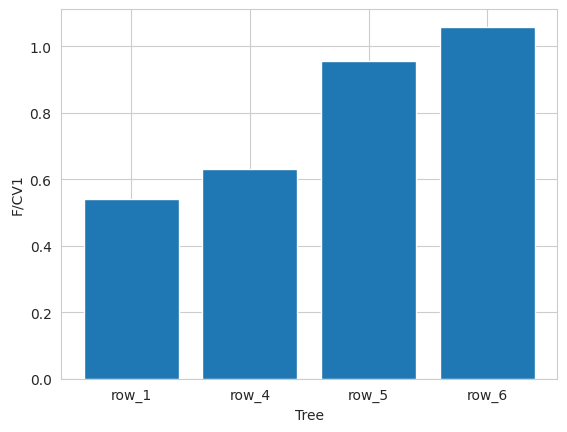

In [65]:
plt.bar(block_48_df['row'], block_48_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

# Block 8

In [89]:
block_3_path = "/home/fruitspec-lab-3/FruitSpec/Data/grapes/SAXXXX/8XXXXXX3"
block_3 = '8XXXXXX3'
block_3_df, row_tracks_3 = block_analysis(block_3_path, metadata_path, block_3)

In [90]:
block_3_df

,block,row,tree,tree_id,F,cv1,cv2,cv3,F/cv1,F/cv2,F/cv3,dcv1,dcv2,dcv3,dcv4,dcv5
0,8XXXXXX3,row_10,1,1,158,304,240,207,0.519737,0.658333,0.763285,286,220,192,171,140
1,8XXXXXX3,row_11,1,1,158,242,199,172,0.652893,0.793970,0.918605,228,177,149,131,112
2,8XXXXXX3,row_12,2,1,172,308,243,204,0.558442,0.707819,0.843137,293,227,185,170,151
3,8XXXXXX3,row_13,2,1,172,287,230,203,0.599303,0.747826,0.847291,272,214,186,165,148


In [91]:
factors_3_dict = linear_model_selection(block_3_df, selection_cols=['cv1','dcv1','cv2','dcv2', 'cv3', 'dcv3'],type_col="block", cross_val='row')

true: 172,    pred: 162.55441662192285. (5.49 %) (row_13)
true: 172,    pred: 179.02221993666134. (4.08 %) (row_12)
true: 158,    pred: 134.95330596442045. (14.59 %) (row_11)
true: 158,    pred: 181.23684355610973. (14.71 %) (row_10)
0.09716920618835773 0.04955054398598642
(0.09716920618835773, 0.04955054398598642)
[0.57465122]
true: 172,    pred: 162.55441662192285. (5.49 %) (row_13)
true: 172,    pred: 179.02221993666134. (4.08 %) (row_12)
true: 158,    pred: 134.95330596442045. (14.59 %) (row_11)
true: 158,    pred: 181.23684355610973. (14.71 %) (row_10)
0.09716920618835773 0.04955054398598642
true: 172,    pred: 162.99020621138374. (5.24 %) (row_13)
true: 172,    pred: 180.50686355672778. (4.95 %) (row_12)
true: 158,    pred: 134.33778230262092. (14.98 %) (row_11)
true: 158,    pred: 179.8549880321221. (13.83 %) (row_10)
0.0974811529110112 0.046747359593763894
(0.0974811529110112, 0.046747359593763894)
[0.60757528]
true: 172,    pred: 162.99020621138374. (5.24 %) (row_13)
true: 172

Text(0, 0.5, 'F/CV1')

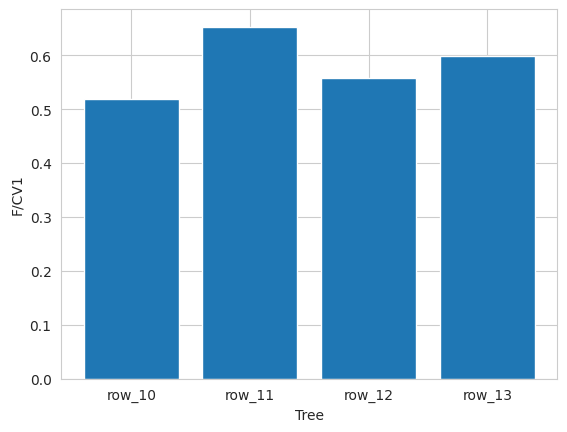

In [92]:
plt.bar(block_3_df['row'], block_3_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [93]:
res, block_3_df_res = get_selection_error(factors_3_dict, block_3_df)

In [94]:
res

{'cv1': {'err': -0.030635284893381794, 'err_std': 0.08662360120280485},
 'dcv1': {'err': -0.027885135291738174, 'err_std': 0.08615769907539705},
 'cv2': {'err': -0.02870603969947688, 'err_std': 0.07132001604535426},
 'dcv2': {'err': -0.02414941462089789, 'err_std': 0.0812457942428986},
 'cv3': {'err': -0.029864128632431746, 'err_std': 0.06809385194371985},
 'dcv3': {'err': -0.035327673404961964, 'err_std': 0.0923643054266149}}

In [95]:
factors_3_dict

{'cv1': {'factor': array([0.59617383]),
  'mean_error': 0.09716920618835773,
  'std_error': 0.04955054398598642},
 'dcv1': {'factor': array([0.62886359]),
  'mean_error': 0.0974811529110112,
  'std_error': 0.046747359593763894},
 'cv2': {'factor': array([0.74429561]),
  'mean_error': 0.07960797048401692,
  'std_error': 0.043855594325000365},
 'dcv2': {'factor': array([0.80695509]),
  'mean_error': 0.08877796399870756,
  'std_error': 0.048903238221894914},
 'cv3': {'factor': array([0.86452152]),
  'mean_error': 0.06769278483469258,
  'std_error': 0.054404421866470855},
 'dcv3': {'factor': array([0.95970205]),
  'mean_error': 0.08665650372910161,
  'std_error': 0.07648342561755163}}

In [ ]:
block_20_path = "/media/matans/My Book/FruitSpec/Apples_SA/020GRANO"
block_20 = '020GRANO'
block_20_df, row_tracks_20 = block_analysis(block_20_path, metadata_path, block_20)

In [ ]:
block_20_df

In [ ]:
factors_20_dict = linear_model_selection(block_20_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')
res, block_20_df_res = get_selection_error(factors_20_dict, block_20_df)

In [ ]:
res

In [ ]:
factors_20_dict

In [ ]:
plt.bar(block_20_df['id'], block_20_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [8]:
block_25_path = "/media/matans/My Book/FruitSpec/Apples_SA/025PINKO"
block_25 = '025PINKO'
block_25_df, row_tracks_25 = block_analysis(block_25_path, metadata_path, block_25)

In [10]:
block_25_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,49,025PINKO,Row_111,10,A,1,Royal Beauty,20,1271,2200,1407,1052,0.577727,1975,1194,883,666,518
1,50,025PINKO,Row_111,13,A,2,Royal Beauty,20,2016,2248,1483,1145,0.896797,1907,1263,984,784,656
2,51,025PINKO,Row_222,13,B,1,Pink Lady,20,2016,1776,1094,812,1.135135,1554,949,688,529,406
3,52,025PINKO,Row_222,10,B,2,Pink Lady,20,1271,1487,880,640,0.854741,1052,546,374,280,201
4,53,025PINKO,Row_333,5,A,1,Royal Beauty,20,1368,1686,1177,905,0.811388,1325,889,678,528,415
5,54,025PINKO,Row_333,6,A,2,Royal Beauty,20,1318,1817,1211,941,0.725371,1337,839,604,458,354


In [11]:
factors_25_dict = linear_model_selection(block_25_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')
res, block_25_df_res = get_selection_error(factors_25_dict, block_25_df)

true: 1318,    pred: 1516.2215697697068. (15.04 %) (54)
true: 1368,    pred: 1380.1481827539994. (0.89 %) (53)
true: 1271,    pred: 1209.4681810662016. (4.84 %) (52)
true: 2016,    pred: 1354.659458139562. (32.80 %) (51)
true: 2016,    pred: 1783.041981035424. (11.56 %) (50)
true: 1271,    pred: 1953.0327778882654. (53.66 %) (49)
0.19798329026685837 0.1820145025573671
(0.19798329026685837, 0.1820145025573671)
[0.81763626]
true: 1318,    pred: 1516.2215697697068. (15.04 %) (54)
true: 1368,    pred: 1380.1481827539994. (0.89 %) (53)
true: 1271,    pred: 1209.4681810662016. (4.84 %) (52)
true: 2016,    pred: 1354.659458139562. (32.80 %) (51)
true: 2016,    pred: 1783.041981035424. (11.56 %) (50)
true: 1271,    pred: 1953.0327778882654. (53.66 %) (49)
0.19798329026685837 0.1820145025573671
true: 1318,    pred: 1318.5091645655996. (0.04 %) (54)
true: 1368,    pred: 1298.2241240254227. (5.10 %) (53)
true: 1271,    pred: 1018.2452076947194. (19.89 %) (52)
true: 2016,    pred: 1436.61619200910

In [12]:
res

{'cv1': {'err': -0.11085505199272717, 'err_std': 0.23175832567980809},
 'dcv1': {'err': -0.12605246841874737, 'err_std': 0.2839817234449111},
 'cv3': {'err': -0.08598332292103583, 'err_std': 0.2472625614113908},
 'dcv3': {'err': -0.06959111558830451, 'err_std': 0.29690962376557434}}

In [13]:
factors_25_dict

{'cv1': {'factor': array([0.88774217]),
  'mean_error': 0.19798329026685837,
  'std_error': 0.1820145025573671},
 'dcv1': {'factor': array([1.11099146]),
  'mean_error': 0.22558164715403917,
  'std_error': 0.24325254614212805},
 'cv3': {'factor': array([1.77183849]),
  'mean_error': 0.240279225430961,
  'std_error': 0.1398454679455019},
 'dcv3': {'factor': array([2.31493664]),
  'mean_error': 0.2444598392089933,
  'std_error': 0.21867421435937526}}

Text(0, 0.5, 'F/CV1')

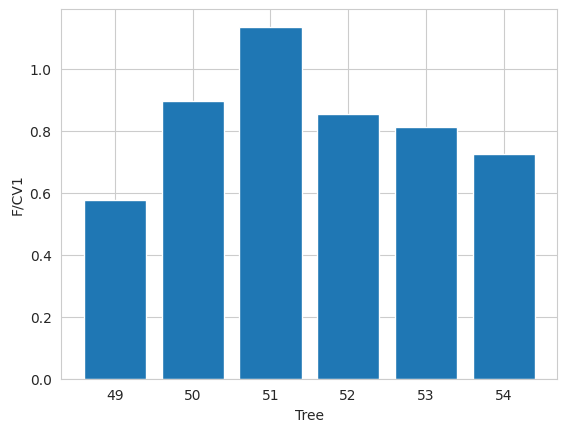

In [14]:
plt.bar(block_25_df['id'], block_25_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [9]:
#row_to_drow = 'row_111'
#tree_id = 1
#date = '221123'
#draw_tree_bb_from_tracks(row_tracks_25[row_to_drow][tree_id], os.path.join(block_25_path, date, row_to_drow, '1'), tree_id)

saving data into: /media/matans/My Book/FruitSpec/Apples_SA/025PINKO/221123/row_111/1/trees/1
arranging data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:09<00:00,  7.09it/s]

Done


In [18]:
block_39_path = "/media/matans/My Book/FruitSpec/Apples_SA/039ROYA0"
block_39 = '039ROYA0'
block_39_df, row_tracks_39 = block_analysis(block_39_path, metadata_path, block_39)

In [16]:
block_39_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,57,039ROYA0,Row_111,1,A,1,Golden Delicious,46,1512,1424,784,525,1.061798,1275,705,466,346,255
1,58,039ROYA0,Row_111,2,A,2,Golden Delicious,46,2414,1632,1062,814,1.479167,1466,945,726,597,482
2,59,039ROYA0,Row_222,2,B,1,Golden Delicious,46,2414,1700,1097,764,1.420000,1439,905,602,399,265
3,60,039ROYA0,Row_222,1,B,2,Golden Delicious,46,1512,83,23,8,18.216867,70,20,7,0,0
4,61,039ROYA0,Row_333,3,A,1,Golden Delicious,46,1460,745,384,281,1.959732,687,362,257,190,142
5,62,039ROYA0,Row_333,4,A,2,Golden Delicious,46,1671,1142,540,321,1.463222,911,420,255,163,112
6,63,039ROYA0,Row_444,4,B,1,Golden Delicious,46,1671,1094,581,369,1.527422,1008,514,318,220,142
7,64,039ROYA0,Row_444,3,B,2,Golden Delicious,46,1460,848,481,317,1.721698,704,397,249,166,94
8,65,039ROYA0,Row_555,6,A,1,Royal Gala,46,919,766,423,293,1.199739,696,391,262,193,129
9,66,039ROYA0,Row_555,5,A,2,Royal Gala,46,1840,1106,521,334,1.663653,917,389,241,150,94


In [19]:
for key in list(row_tracks_39.keys()):
    print(f'number of sections in row {key} is {len(list(row_tracks_39[key].keys()))}')

number of sections in row row_111 is 2
number of sections in row row_222 is 2
number of sections in row row_333 is 2
number of sections in row row_444 is 2
number of sections in row row_555 is 3
number of sections in row row_666 is 2
number of sections in row row_777 is 2
number of sections in row row_888 is 2
